### Imports

In [ ]:
# LDA topic models visualization tool
!pip install pyLDAvis
# wordnet
!pip install wordnet
# Uniform Manifold Approximation and Projection for LSA visualization
#!pip install umap-learn
# bert topic algo
!pip install bertopic
# bert topic visualization
!pip install bertopic[visualization]

In [ ]:
import nltk
import numpy as np
import pandas as pd
import re
import nltk
import spacy
import string
import seaborn as sns
import matplotlib.pyplot as plt
import umap.umap_ as umap
import gensim
import pyLDAvis
import pyLDAvis.gensim_models as gmod
import warnings

from nltk.corpus import words, stopwords, wordnet
from google.colab import drive
from wordcloud import WordCloud
from nltk.stem import WordNetLemmatizer
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from gensim import corpora, models
from pprint import pprint
from bertopic import BERTopic
from gensim.models import CoherenceModel

nltk.download('all')
pd.options.mode.chained_assignment = None
warnings.filterwarnings('ignore')

### Data Loading

In [3]:
# mount drive
drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


In [ ]:
full_df = pd.read_csv("/content/gdrive/MyDrive/twcs.csv")

# in_response_to_tweet_id = was this tweet a response to some other tweet? [tweet id]
full_df[['in_response_to_tweet_id']] = full_df[['in_response_to_tweet_id']].astype('Int64')

print("Shape of the data frame = ", full_df.shape)
full_df.head()

Shape of the data frame =  (2811774, 7)


tweet_id   author_id  inbound                      created_at  \
0         1  sprintcare    False  Tue Oct 31 22:10:47 +0000 2017   
1         2      115712     True  Tue Oct 31 22:11:45 +0000 2017   
2         3      115712     True  Tue Oct 31 22:08:27 +0000 2017   
3         4  sprintcare    False  Tue Oct 31 21:54:49 +0000 2017   
4         5      115712     True  Tue Oct 31 21:49:35 +0000 2017   

                                                text response_tweet_id  \
0  @115712 I understand. I would like to assist y...                 2   
1      @sprintcare and how do you propose we do that               NaN   
2  @sprintcare I have sent several private messag...                 1   
3  @115712 Please send us a Private Message so th...                 3   
4                                 @sprintcare I did.                 4   

   in_response_to_tweet_id  
0                        3  
1                        1  
2                        4  
3                        5  
4                        6

In [ ]:
top20 = full_df[['author_id']].value_counts().iloc[:20].rename_axis('val').reset_index(name='count')
top20

val   count
0        AmazonHelp  169840
1      AppleSupport  106860
2      Uber_Support   56270
3      SpotifyCares   43265
4             Delta   42253
5             Tesco   38573
6       AmericanAir   36764
7       TMobileHelp   34317
8      comcastcares   33031
9   British_Airways   29361
10     SouthwestAir   28977
11     VirginTrains   27817
12     Ask_Spectrum   25860
13      XboxSupport   24557
14       sprintcare   22381
15     hulu_support   21872
16       sainsburys   19466
17          GWRHelp   19364
18   AskPlayStation   19098
19   ChipotleTweets   18749

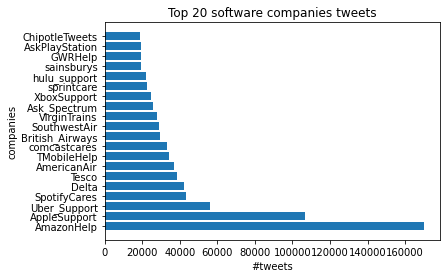

In [ ]:
top20_plot = plt.barh(list(top20["val"]), list(top20["count"]))

plt.ylabel("companies")
plt.xlabel("#tweets")
plt.title("Top 20 software companies tweets")
plt.show()

Now here we can see that Amazon, Apple, Uber, Spotify are the only big software related companies.

So we will make 4 new datasets which has inbound tweets from this 4 companies respectively. Intially we will just analyse the inbound tweets (incoming tweets) done to these 4 companies.

We will figure out the input tweets which are directed towards this 4 companies by checking two conditions.

1) We take out tweets which are outbound by this 4 organizations and we will extract the tweet they were replying to.

2) If they are inbound tweet we put it in the dataset of that particular organization (this column will help us seperate reply tweets from inbound tweets)

### Preprocessing

In [ ]:
full_df['in_response_to_tweet_id'] = full_df['in_response_to_tweet_id'].fillna(-1)

In [ ]:
# 10 most frequent words
cnt = Counter()
for text in full_df["text"].values:
    for word in text.split():
        cnt[word] += 1
        
cnt.most_common(10)

[('to', 1665886),
 ('the', 1404700),
 ('you', 987068),
 ('a', 866701),
 ('I', 830261),
 ('and', 795898),
 ('for', 746088),
 ('your', 681298),
 ('is', 472403),
 ('on', 451844)]

In [ ]:
emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)


In [ ]:
wordnet_map = {"N":wordnet.NOUN, "V":wordnet.VERB, "J":wordnet.ADJ, "R":wordnet.ADV}

In [ ]:
EMOTICONS = {
    u":‑\)":"Happy face or smiley",
    u":\)":"Happy face or smiley",
    u":-\]":"Happy face or smiley",
    u":\]":"Happy face or smiley",
    u":-3":"Happy face smiley",
    u":3":"Happy face smiley",
    u":->":"Happy face smiley",
    u":>":"Happy face smiley",
    u"8-\)":"Happy face smiley",
    u":o\)":"Happy face smiley",
    u":-\}":"Happy face smiley",
    u":\}":"Happy face smiley",
    u":-\)":"Happy face smiley",
    u":c\)":"Happy face smiley",
    u":\^\)":"Happy face smiley",
    u"=\]":"Happy face smiley",
    u"=\)":"Happy face smiley",
    u":‑D":"Laughing, big grin or laugh with glasses",
    u":D":"Laughing, big grin or laugh with glasses",
    u"8‑D":"Laughing, big grin or laugh with glasses",
    u"8D":"Laughing, big grin or laugh with glasses",
    u"X‑D":"Laughing, big grin or laugh with glasses",
    u"XD":"Laughing, big grin or laugh with glasses",
    u"=D":"Laughing, big grin or laugh with glasses",
    u"=3":"Laughing, big grin or laugh with glasses",
    u"B\^D":"Laughing, big grin or laugh with glasses",
    u":-\)\)":"Very happy",
    u":‑\(":"Frown, sad, andry or pouting",
    u":-\(":"Frown, sad, andry or pouting",
    u":\(":"Frown, sad, andry or pouting",
    u":‑c":"Frown, sad, andry or pouting",
    u":c":"Frown, sad, andry or pouting",
    u":‑<":"Frown, sad, andry or pouting",
    u":<":"Frown, sad, andry or pouting",
    u":‑\[":"Frown, sad, andry or pouting",
    u":\[":"Frown, sad, andry or pouting",
    u":-\|\|":"Frown, sad, andry or pouting",
    u">:\[":"Frown, sad, andry or pouting",
    u":\{":"Frown, sad, andry or pouting",
    u":@":"Frown, sad, andry or pouting",
    u">:\(":"Frown, sad, andry or pouting",
    u":'‑\(":"Crying",
    u":'\(":"Crying",
    u":'‑\)":"Tears of happiness",
    u":'\)":"Tears of happiness",
    u"D‑':":"Horror",
    u"D:<":"Disgust",
    u"D:":"Sadness",
    u"D8":"Great dismay",
    u"D;":"Great dismay",
    u"D=":"Great dismay",
    u"DX":"Great dismay",
    u":‑O":"Surprise",
    u":O":"Surprise",
    u":‑o":"Surprise",
    u":o":"Surprise",
    u":-0":"Shock",
    u"8‑0":"Yawn",
    u">:O":"Yawn",
    u":-\*":"Kiss",
    u":\*":"Kiss",
    u":X":"Kiss",
    u";‑\)":"Wink or smirk",
    u";\)":"Wink or smirk",
    u"\*-\)":"Wink or smirk",
    u"\*\)":"Wink or smirk",
    u";‑\]":"Wink or smirk",
    u";\]":"Wink or smirk",
    u";\^\)":"Wink or smirk",
    u":‑,":"Wink or smirk",
    u";D":"Wink or smirk",
    u":‑P":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u":P":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u"X‑P":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u"XP":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u":‑Þ":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u":Þ":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u":b":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u"d:":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u"=p":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u">:P":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u":‑/":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u":/":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u":-[.]":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u">:[(\\\)]":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u">:/":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u":[(\\\)]":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u"=/":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u"=[(\\\)]":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u":L":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u"=L":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u":S":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u":‑\|":"Straight face",
    u":\|":"Straight face",
    u":$":"Embarrassed or blushing",
    u":‑x":"Sealed lips or wearing braces or tongue-tied",
    u":x":"Sealed lips or wearing braces or tongue-tied",
    u":‑#":"Sealed lips or wearing braces or tongue-tied",
    u":#":"Sealed lips or wearing braces or tongue-tied",
    u":‑&":"Sealed lips or wearing braces or tongue-tied",
    u":&":"Sealed lips or wearing braces or tongue-tied",
    u"O:‑\)":"Angel, saint or innocent",
    u"O:\)":"Angel, saint or innocent",
    u"0:‑3":"Angel, saint or innocent",
    u"0:3":"Angel, saint or innocent",
    u"0:‑\)":"Angel, saint or innocent",
    u"0:\)":"Angel, saint or innocent",
    u":‑b":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u"0;\^\)":"Angel, saint or innocent",
    u">:‑\)":"Evil or devilish",
    u">:\)":"Evil or devilish",
    u"\}:‑\)":"Evil or devilish",
    u"\}:\)":"Evil or devilish",
    u"3:‑\)":"Evil or devilish",
    u"3:\)":"Evil or devilish",
    u">;\)":"Evil or devilish",
    u"\|;‑\)":"Cool",
    u"\|‑O":"Bored",
    u":‑J":"Tongue-in-cheek",
    u"#‑\)":"Party all night",
    u"%‑\)":"Drunk or confused",
    u"%\)":"Drunk or confused",
    u":-###..":"Being sick",
    u":###..":"Being sick",
    u"<:‑\|":"Dump",
    u"\(>_<\)":"Troubled",
    u"\(>_<\)>":"Troubled",
    u"\(';'\)":"Baby",
    u"\(\^\^>``":"Nervous or Embarrassed or Troubled or Shy or Sweat drop",
    u"\(\^_\^;\)":"Nervous or Embarrassed or Troubled or Shy or Sweat drop",
    u"\(-_-;\)":"Nervous or Embarrassed or Troubled or Shy or Sweat drop",
    u"\(~_~;\) \(・\.・;\)":"Nervous or Embarrassed or Troubled or Shy or Sweat drop",
    u"\(-_-\)zzz":"Sleeping",
    u"\(\^_-\)":"Wink",
    u"\(\(\+_\+\)\)":"Confused",
    u"\(\+o\+\)":"Confused",
    u"\(o\|o\)":"Ultraman",
    u"\^_\^":"Joyful",
    u"\(\^_\^\)/":"Joyful",
    u"\(\^O\^\)／":"Joyful",
    u"\(\^o\^\)／":"Joyful",
    u"\(__\)":"Kowtow as a sign of respect, or dogeza for apology",
    u"_\(\._\.\)_":"Kowtow as a sign of respect, or dogeza for apology",
    u"<\(_ _\)>":"Kowtow as a sign of respect, or dogeza for apology",
    u"<m\(__\)m>":"Kowtow as a sign of respect, or dogeza for apology",
    u"m\(__\)m":"Kowtow as a sign of respect, or dogeza for apology",
    u"m\(_ _\)m":"Kowtow as a sign of respect, or dogeza for apology",
    u"\('_'\)":"Sad or Crying",
    u"\(/_;\)":"Sad or Crying",
    u"\(T_T\) \(;_;\)":"Sad or Crying",
    u"\(;_;":"Sad of Crying",
    u"\(;_:\)":"Sad or Crying",
    u"\(;O;\)":"Sad or Crying",
    u"\(:_;\)":"Sad or Crying",
    u"\(ToT\)":"Sad or Crying",
    u";_;":"Sad or Crying",
    u";-;":"Sad or Crying",
    u";n;":"Sad or Crying",
    u";;":"Sad or Crying",
    u"Q\.Q":"Sad or Crying",
    u"T\.T":"Sad or Crying",
    u"QQ":"Sad or Crying",
    u"Q_Q":"Sad or Crying",
    u"\(-\.-\)":"Shame",
    u"\(-_-\)":"Shame",
    u"\(一一\)":"Shame",
    u"\(；一_一\)":"Shame",
    u"\(=_=\)":"Tired",
    u"\(=\^\·\^=\)":"cat",
    u"\(=\^\·\·\^=\)":"cat",
    u"=_\^=	":"cat",
    u"\(\.\.\)":"Looking down",
    u"\(\._\.\)":"Looking down",
    u"\^m\^":"Giggling with hand covering mouth",
    u"\(\・\・?":"Confusion",
    u"\(?_?\)":"Confusion",
    u">\^_\^<":"Normal Laugh",
    u"<\^!\^>":"Normal Laugh",
    u"\^/\^":"Normal Laugh",
    u"\（\*\^_\^\*）" :"Normal Laugh",
    u"\(\^<\^\) \(\^\.\^\)":"Normal Laugh",
    u"\(^\^\)":"Normal Laugh",
    u"\(\^\.\^\)":"Normal Laugh",
    u"\(\^_\^\.\)":"Normal Laugh",
    u"\(\^_\^\)":"Normal Laugh",
    u"\(\^\^\)":"Normal Laugh",
    u"\(\^J\^\)":"Normal Laugh",
    u"\(\*\^\.\^\*\)":"Normal Laugh",
    u"\(\^—\^\）":"Normal Laugh",
    u"\(#\^\.\^#\)":"Normal Laugh",
    u"\（\^—\^\）":"Waving",
    u"\(;_;\)/~~~":"Waving",
    u"\(\^\.\^\)/~~~":"Waving",
    u"\(-_-\)/~~~ \($\·\·\)/~~~":"Waving",
    u"\(T_T\)/~~~":"Waving",
    u"\(ToT\)/~~~":"Waving",
    u"\(\*\^0\^\*\)":"Excited",
    u"\(\*_\*\)":"Amazed",
    u"\(\*_\*;":"Amazed",
    u"\(\+_\+\) \(@_@\)":"Amazed",
    u"\(\*\^\^\)v":"Laughing,Cheerful",
    u"\(\^_\^\)v":"Laughing,Cheerful",
    u"\(\(d[-_-]b\)\)":"Headphones,Listening to music",
    u'\(-"-\)':"Worried",
    u"\(ーー;\)":"Worried",
    u"\(\^0_0\^\)":"Eyeglasses",
    u"\(\＾ｖ\＾\)":"Happy",
    u"\(\＾ｕ\＾\)":"Happy",
    u"\(\^\)o\(\^\)":"Happy",
    u"\(\^O\^\)":"Happy",
    u"\(\^o\^\)":"Happy",
    u"\)\^o\^\(":"Happy",
    u":O o_O":"Surprised",
    u"o_0":"Surprised",
    u"o\.O":"Surpised",
    u"\(o\.o\)":"Surprised",
    u"oO":"Surprised",
    u"\(\*￣m￣\)":"Dissatisfied",
    u"\(‘A`\)":"Snubbed or Deflated"
}

In [ ]:
emoticon_pattern = re.compile(u'(' + u'|'.join(k for k in EMOTICONS) + u')')
url_pattern = re.compile(r'https?://\S+|www\.\S+')
html_pattern = re.compile('<.*?>')
user_id_pattern = re.compile('(@\d+)')

In [ ]:
def preprocessTweets(text, company_handle):
  ''' 
    Function to clean all the tweets by removing urls, stopwords, emojis, etc. 
  '''
  # removal of urls
  text = url_pattern.sub(r'', text)
  # removal of company handle
  text = text.replace(company_handle.lower(), '')
  # removal of user ids
  text = user_id_pattern.sub(r'', text)
  # remove punctuations
  text = text.translate(str.maketrans('', '', string.punctuation))
  # removal of stopwords
  text = " ".join([word for word in str(text).split() if word not in set(stopwords.words('english'))])
  # lemmatization
  # pos_tagged_text = nltk.pos_tag(text.split())
  # text = " ".join([lemmatizer.lemmatize(word, wordnet_map.get(pos[0], wordnet.NOUN)) for word, pos in pos_tagged_text])
  # removal of emojis
  text = emoji_pattern.sub(r'', text)
  # removal of emoticons
  text = emoticon_pattern.sub(r'', text)
  # removal of html tags
  text = html_pattern.sub(r'', text)
  # removal of standalone numbers
  text = re.sub("^\d+\s|\s\d+\s|\s\d+$", " ", text) # can't remove a string with only 1 number
  # removal of unnecessary spaces
  text = re.sub(r'\s+',' ', text)
  return text

### Functions

In [ ]:
def extractTweetsToCompany(twitter_handle):
  ''' 
    Function to get all the tweets made to a particular twitter handle 
  '''
  # tweets that the company wrote
  tweets_by_company = full_df.loc[full_df['author_id'] == twitter_handle]
  # tweet ids that the company replied to
  tweet_ids_company_replied_to = tweets_by_company['in_response_to_tweet_id'].tolist()
  # software tweets made by people to the company
  tweets_to_company = full_df[full_df.tweet_id.isin(tweet_ids_company_replied_to)]
  # considering only those tweets sent to the company
  tweets_to_company = tweets_to_company[tweets_to_company.inbound.isin([True])]
  # only english tweets
  tweets_to_company = tweets_to_company[tweets_to_company['text'].map(lambda x: x.isascii())]
  # text to lowercase
  tweets_to_company['text'] = tweets_to_company['text'].str.lower()
  return tweets_to_company

In [ ]:
def tweetsWordsDistribution(df):
  ''' 
    Function to get a histogram of number of tweets vs tweet length 
  '''
  df.str.split().map(lambda x: len(x)).hist()

In [ ]:
def frequentWordsWordCloud(tweets):
  ''' 
    Function to get a word cloud of the frequent words in the tweet dataset of 
    each company 
  '''
  word_cloud = WordCloud(width = 1000,
                        height = 800,
                        colormap = 'Blues', 
                        margin = 0,
                        max_words = 200,  
                        min_word_length = 4,
                        max_font_size = 120, 
                        min_font_size = 15,  
                        background_color = "white").generate(" ".join(tweets))

  plt.figure(figsize = (10, 15))
  plt.imshow(word_cloud, interpolation = "gaussian")
  plt.axis("off")
  plt.show()

In [ ]:
def get_top_ngram(corpus, n=None):
  ''' 
    Function to get top 10 n grams where n can be 1, 2, 3 ...  
  '''
  vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
  bag_of_words = vec.transform(corpus)
  sum_words = bag_of_words.sum(axis = 0) 
  words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
  words_freq = sorted(words_freq, key = lambda x: x[1], reverse = True)
  return words_freq[:10]

In [ ]:
def visualizeNGrams(tweets, n):
  ''' 
    Function to plot a graph for n gram vs its frequency 
  '''
  top_ngrams = get_top_ngram(tweets, n)[:10]
  x, y = map(list, zip(*top_ngrams))
  sns.barplot(x = y, y = x)

In [ ]:
def vectorizeTweets(doc_term_matrix, n_topics):
  # SVD represent documents and terms in vectors 
  svd_model = TruncatedSVD(n_components=n_topics, algorithm='randomized', n_iter=100, random_state=122)
  svd_model.fit(doc_term_matrix)
  return svd_model

In [ ]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.LdaMulticore(corpus=corpus, id2word=dictionary, num_topics=num_topics)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [ ]:
def coherencePlot(dictionary, corpus, docs):
  model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=corpus, texts=docs, start=2, limit=40, step=6)
  # Show graph
  import matplotlib.pyplot as plt
  limit=40; start=2; step=6;
  x = range(start, limit, step)
  plt.plot(x, coherence_values)
  plt.xlabel("Num Topics")
  plt.ylabel("Coherence score")
  plt.legend(("coherence_values"), loc='best')
  plt.show()

## Topic Modelling Algorithms

In [ ]:
def lsaAlgo(tweets, max_f, n_topics):
  ''' 
     words that occur together in a document tend to have similar meanings, 
     and LSA seeks to extract those meaning by analyzing the relationships between 
     the words and the documents in which they occur
  '''
  vectorizer = TfidfVectorizer(stop_words='english', max_features= max_f, max_df = 0.5, smooth_idf=True)
  # document-term matrix
  X = vectorizer.fit_transform(tweets.values.astype('U')) # unicode string
  print("Doc-term matrix shape: ", X.shape)
  print()

  # svd vectorization
  svd_model = vectorizeTweets(X, n_topics)
  terms = vectorizer.get_feature_names()
  for i, comp in enumerate(svd_model.components_):
      terms_comp = zip(terms, comp)
      sorted_terms = sorted(terms_comp, key=lambda x:x[1], reverse=True)[:7]
      print("Topic "+str(i)+": ", end = ' ')
      for t in sorted_terms:
          print(t[0], end = ' ')
      print()

  # umap visualization
  X_topics = svd_model.fit_transform(X)
  embedding = umap.UMAP(n_neighbors=100, min_dist=0.5, random_state=12).fit_transform(X_topics)

  plt.figure(figsize=(14,10))
  plt.scatter(embedding[:, 0], embedding[:, 1], s = 10, edgecolor='none')
  plt.show()

In [ ]:
def ldaAlgo(tweets, isBow, n_topics):
  docs = tweets.map(lambda row: row.split(' '))
  dictionary = gensim.corpora.Dictionary(docs)
  dictionary.filter_extremes(no_below=15, no_above=0.5, keep_n=100000)

  corpus = [dictionary.doc2bow(doc) for doc in docs]

  if isBow == False:
    tfidf = models.TfidfModel(corpus)
    corpus = tfidf[corpus]
    
  lda_model = gensim.models.LdaMulticore(corpus, num_topics=n_topics, id2word=dictionary, passes=2, workers=4)

  # compute coherence for this model
  coherence_model_lda_cv = CoherenceModel(model=lda_model, texts=docs, dictionary=dictionary, coherence='c_v')
  coherence_model_lda_umass = CoherenceModel(model=lda_model, texts=docs, dictionary=dictionary, coherence='u_mass')
  print('\nCoherence Score (c_v): ', coherence_model_lda_cv.get_coherence())
  print('\nCoherence Score (u_mass): ', coherence_model_lda_umass.get_coherence())
  print()

  for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} Words: {}'.format(idx, topic))

  coherencePlot(dictionary, corpus, docs)

  # pyldavis
  vis = gmod.prepare(topic_model=lda_model, corpus=corpus, dictionary=dictionary)
  return vis

In [4]:
def bertTopic(company, n_topics, tweets):
  model = BERTopic(calculate_probabilities=True, nr_topics=n_topics)
  topics, probabilities = model.fit_transform(np.array(tweets.text))
  model.get_topic_freq().head()
  # print n topics
  for i in range(n_topics):
    print("Topic " + str(i) + ": ", model.get_topic(i))
  # save model
  # model.save("bert_topic_model_"+company)
  return model

## Apple

In [ ]:
company = 'AppleSupport'

In [ ]:
apple_tweets = pd.read_csv("/content/gdrive/MyDrive/ai4se/pp_files/apple.csv")
apple_tweets = apple_tweets.dropna()
apple_tweets.head()

Unnamed: 0                                       text
1         402  tried resetting settings restarting phone
2         404                                 looks like
3         415                                  happening
4         417                          tf wrong keyboard
5         419                  call centres closed night

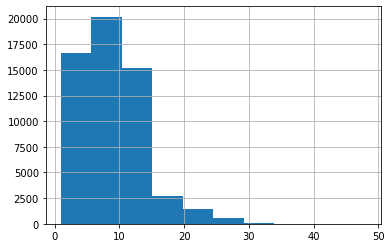

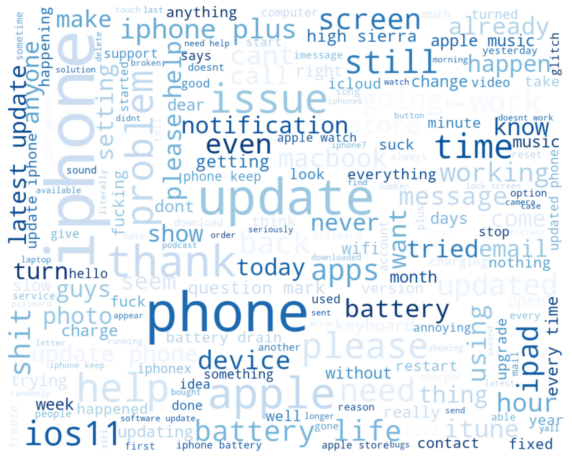

In [ ]:
tweetsWordsDistribution(apple_tweets.text)
frequentWordsWordCloud(apple_tweets.text)

Top 10 Unigrams


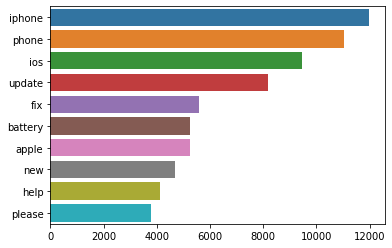

In [ ]:
print("Top 10 Unigrams")
visualizeNGrams(apple_tweets.text, 1)

Top 10 Bigrams


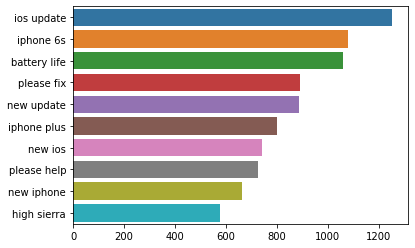

In [ ]:
print("Top 10 Bigrams")
visualizeNGrams(apple_tweets.text, 2)

Top 10 Trigrams


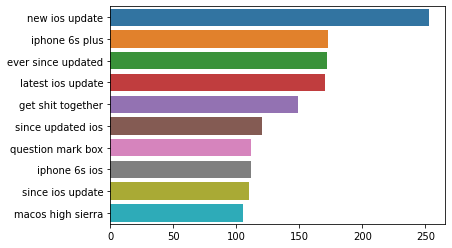

In [ ]:
print("Top 10 Trigrams")
visualizeNGrams(apple_tweets.text, 3)

Doc-term matrix shape:  (56724, 1000)

Topic 0:  ios iphone update phone fix battery new 
Topic 1:  fix phone update shit new help glitch 
Topic 2:  fix ios shit glitch battery bug life 
Topic 3:  iphone fix help plus 6s shit glitch 
Topic 4:  help ios fix need pls apple hi 
Topic 5:  yes fix ios help thank issue app 
Topic 6:  update battery life new help latest draining 
Topic 7:  thanks apple music app thank store watch 
Topic 8:  thanks phone help iphone fix update 6s 
Topic 9:  battery life phone thanks draining ios11 updated 
Topic 10:  thank worked fixed problem battery response got 
Topic 11:  apple phone shit new watch iphone music 
Topic 12:  wtf shit new like question mark fuck 
Topic 13:  6s wtf plus update shit latest updated 
Topic 14:  new 6s shit app plus screen apps 
Topic 15:  issue wtf 6s new plus going fixed 
Topic 16:  problem 6s new wtf plus got going 
Topic 17:  shit updated problem issue question mark apple 
Topic 18:  updated new wtf fix apps 6s music 
Topic 19

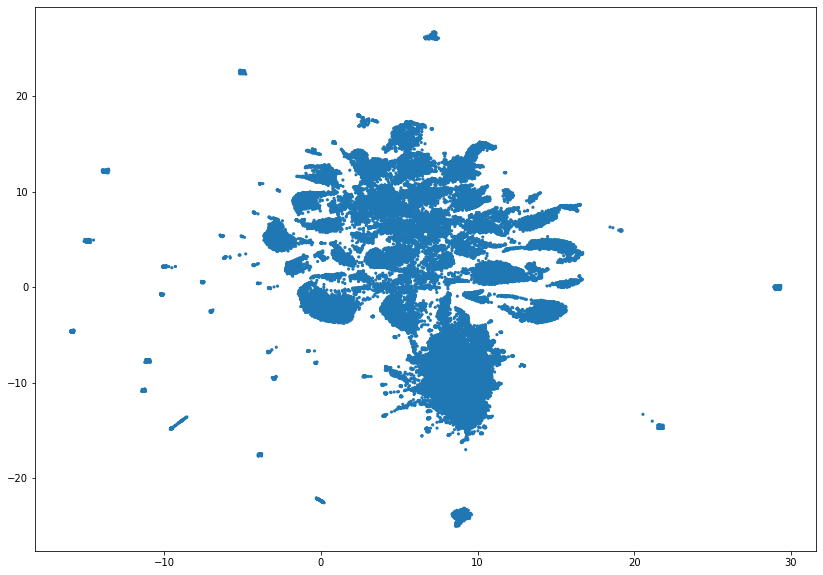

In [ ]:
# LSA topic modeling: considering 1000 features and 20 topics
lsaAlgo(apple_tweets.text, 1000, 20)


Coherence Score (c_v):  0.3000074413877563

Coherence Score (u_mass):  -5.201270786202899

Topic: 0 Words: 0.031*"thanks" + 0.021*"music" + 0.018*"apple" + 0.011*"iphone" + 0.010*"watch" + 0.010*"itunes" + 0.010*"phone" + 0.009*"update" + 0.009*"ios" + 0.008*"songs"
Topic: 1 Words: 0.020*"1112" + 0.016*"bug" + 0.014*"fix" + 0.011*"hey" + 0.010*"iphone" + 0.010*"ios" + 0.009*"5s" + 0.009*"phone" + 0.009*"autocorrect" + 0.008*"update"
Topic: 2 Words: 0.055*"fix" + 0.032*"shit" + 0.017*"phone" + 0.013*"fucked" + 0.011*"update" + 0.011*"together" + 0.010*"yall" + 0.010*"please" + 0.010*"glitching" + 0.009*"ios"
Topic: 3 Words: 0.042*"wtf" + 0.036*"question" + 0.024*"mark" + 0.016*"box" + 0.014*"fix" + 0.013*"marks" + 0.011*"shit" + 0.011*"phone" + 0.010*"nope" + 0.009*"still"
Topic: 4 Words: 0.010*"please" + 0.010*"fix" + 0.009*"update" + 0.009*"phone" + 0.008*"ios" + 0.007*"apps" + 0.007*"iphone" + 0.007*"app" + 0.007*"photos" + 0.006*"scam"
Topic: 5 Words: 0.026*"happening" + 0.011*"iph

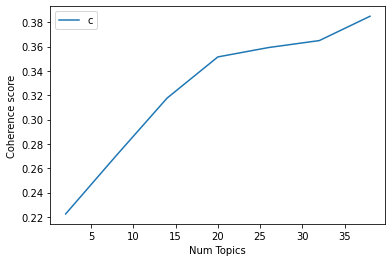

In [ ]:
# LDA topic modeling: considering tf-idf and 20 topics
pyLDAvis.enable_notebook()
pyLDAvis.display(ldaAlgo(apple_tweets.text, False, 20))

In [ ]:
model = bertTopic(company, 20, apple_tweets)
model.visualize_topics()

Topic 0:  [('fix', 0.12737126459158946), ('version', 0.08856265814968037), ('update', 0.0818813958169489), ('shit', 0.057254177180570874), ('updated', 0.05567800210848426), ('latest', 0.05038018791265426), ('ios', 0.04133671591943443), ('fixed', 0.03660862388821126), ('issue', 0.03469026986043462), ('one', 0.03426321624214188)]
Topic 1:  [('freezing', 0.10427254534453487), ('freezes', 0.06481193324035792), ('crashing', 0.05665308474745087), ('phone', 0.055258888702003864), ('keeps', 0.048810530975260565), ('apps', 0.04507527667152675), ('update', 0.040788890308326664), ('iphone', 0.04036088794798412), ('ios', 0.039725883291689384), ('freeze', 0.03819088737478486)]
Topic 2:  [('phone', 0.10242837720816328), ('update', 0.09940947336868519), ('wtf', 0.0628942383072743), ('fucked', 0.04841779728286313), ('shit', 0.042639954493232594), ('happening', 0.040628163815316906), ('new', 0.039126680507528974), ('fuck', 0.03808159848972763), ('ios', 0.03160639671086279), ('fix', 0.028964745120849532

In [ ]:
# run only once
apple_tweets = extractTweetsToCompany(company)
print("Apple tweets shape = ", apple_tweets.shape)
apple_tweets['text'] = apple_tweets.apply(lambda row: preprocessTweets(row['text'], company), axis = 1)
apple_tweets.head()

Apple tweets shape =  (57769, 7)


tweet_id author_id  inbound                      created_at  \
399       698    115854     True  Tue Oct 31 22:17:40 +0000 2017   
402       702    115855     True  Tue Oct 31 22:11:31 +0000 2017   
404       704    115855     True  Tue Oct 31 21:59:17 +0000 2017   
415       717    115857     True  Tue Oct 31 22:13:08 +0000 2017   
417       719    115857     True  Tue Oct 31 22:01:50 +0000 2017   

                                          text response_tweet_id  \
399                                                          696   
402  tried resetting settings restarting phone               701   
404                                 looks like               703   
415                                  happening               716   
417                          tf wrong keyboard               718   

     in_response_to_tweet_id  
399                      700  
402                      703  
404                      705  
415                      718  
417                       -1

In [ ]:
# run only once
apple_tweets = apple_tweets['text']
apple_tweets.head()

399                                             
402    tried resetting settings restarting phone
404                                   looks like
415                                    happening
417                            tf wrong keyboard
Name: text, dtype: object

In [ ]:
# run only once
# convert dataframe to csv
apple_tweets.to_csv('/content/apple.csv')

## Amazon

In [20]:
company = 'AmazonHelp'

In [21]:
amazon_tweets = pd.read_csv("/content/gdrive/MyDrive/ai4se/pp_files/amazon.csv")
amazon_tweets = amazon_tweets.dropna()
amazon_tweets.head()

Unnamed: 0                                               text
0         322   different people given different answers stil...
1         325        way drop ball customer service pissed right
2         327      want amazon payments account closed dm please
3         331  also beim addams familyfilm prime sind bild un...
4         342  thanks style advice look think halloween2017 f...

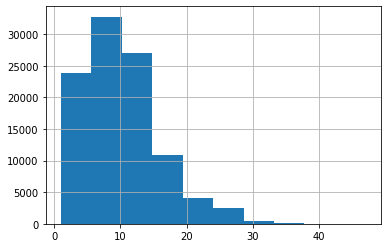

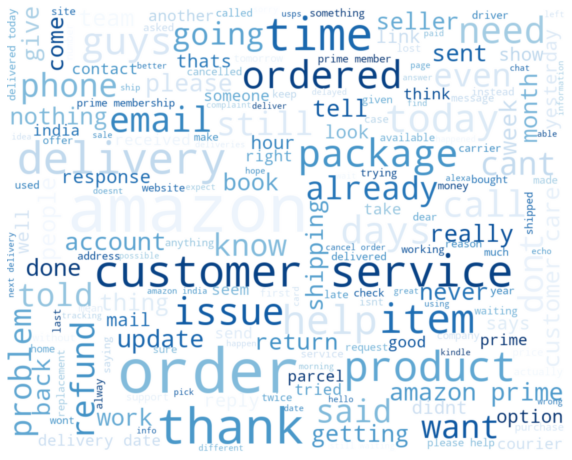

In [ ]:
tweetsWordsDistribution(amazon_tweets.text)
frequentWordsWordCloud(amazon_tweets.text)

Top 10 Unigrams


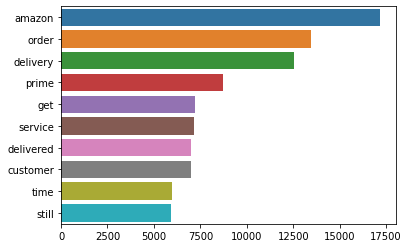

In [ ]:
print("Top 10 Unigrams")
visualizeNGrams(amazon_tweets.text, 1)

Top 10 Bigrams


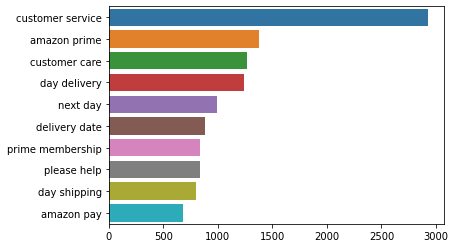

In [ ]:
print("Top 10 Bigrams")
visualizeNGrams(amazon_tweets.text, 2)

Top 10 Trigrams


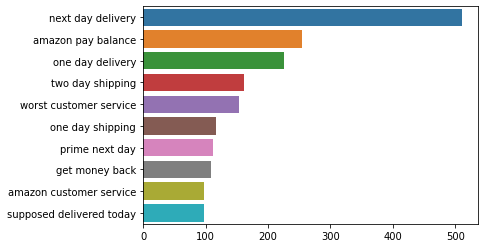

In [ ]:
print("Top 10 Trigrams")
visualizeNGrams(amazon_tweets.text, 3)

Doc-term matrix shape:  (101749, 1000)

Topic 0:  amazon order delivery prime delivered service customer 
Topic 1:  amazon prime account india logistics pay por 
Topic 2:  delivery day prime today package days shipping 
Topic 3:  customer service help thanks email care thank 
Topic 4:  service customer order worst care pathetic delivery 
Topic 5:  yes email account received sent details times 
Topic 6:  thanks yes order service customer amazon worst 
Topic 7:  prime help yes order day membership days 
Topic 8:  email prime account sent days membership received 
Topic 9:  delivery email amazon order date sent details 
Topic 10:  thank prime ok order today package got 
Topic 11:  time product refund dont want thank money 
Topic 12:  product received refund ordered days day return 
Topic 13:  days day package shipping waiting refund im 
Topic 14:  time received email help days product ordered 
Topic 15:  today ordered time got received item arrive 
Topic 16:  package refund account receiv

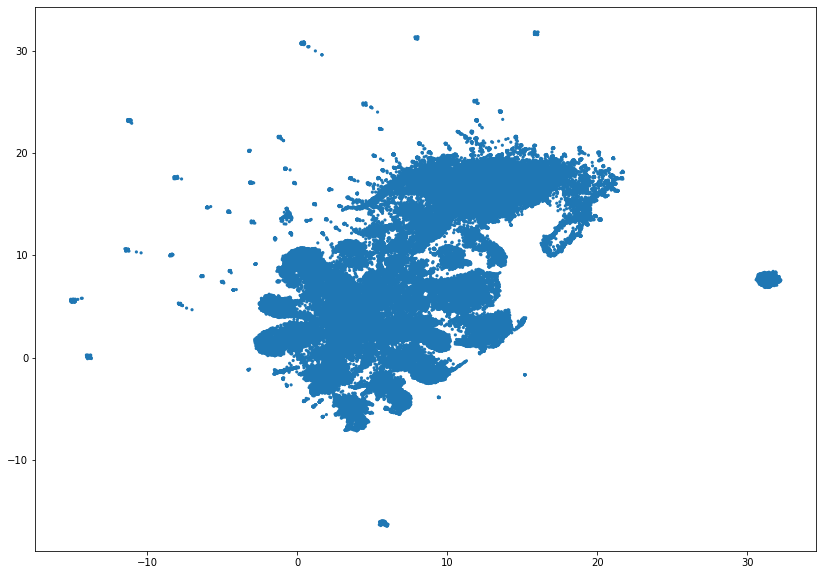

In [ ]:
# LSA topic modeling: considering 1000 features and 20 topics
lsaAlgo(amazon_tweets.text, 1000, 20)


Coherence Score (c_v):  0.39927686518368366

Coherence Score (u_mass):  -5.770768674545023

Topic: 0 Words: 0.016*"merci" + 0.009*"amazon" + 0.008*"sorted" + 0.008*"fulfilled" + 0.006*"order" + 0.006*"get" + 0.005*"invoice" + 0.005*"pending" + 0.005*"pour" + 0.005*"hopefully"
Topic: 1 Words: 0.036*"thank" + 0.013*"ok" + 0.008*"much" + 0.007*"amazon" + 0.007*"box" + 0.006*"answer" + 0.006*"service" + 0.006*"customer" + 0.006*"thanks" + 0.005*"help"
Topic: 2 Words: 0.029*"thanks" + 0.021*"us" + 0.019*"amzl" + 0.011*"carrier" + 0.009*"amazon" + 0.009*"prime" + 0.007*"app" + 0.007*"video" + 0.007*"music" + 0.006*"im"
Topic: 3 Words: 0.035*"de" + 0.028*"gracias" + 0.025*"que" + 0.019*"el" + 0.019*"por" + 0.017*"la" + 0.016*"en" + 0.013*"un" + 0.012*"con" + 0.012*"mi"
Topic: 4 Words: 0.018*"delivery" + 0.017*"yes" + 0.016*"delivered" + 0.015*"today" + 0.015*"package" + 0.014*"day" + 0.011*"says" + 0.009*"prime" + 0.009*"yesterday" + 0.009*"order"
Topic: 5 Words: 0.014*"order" + 0.010*"yet" 

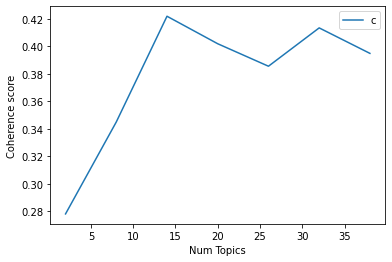

In [ ]:
# LDA topic modeling: considering tf-idf and 20 topics
pyLDAvis.enable_notebook()
pyLDAvis.display(ldaAlgo(amazon_tweets.text, False, 20))

In [22]:
model = bertTopic(company, 20, amazon_tweets)
model.visualize_topics()

Topic 0:  [('prime', 0.13482621447585824), ('day', 0.04730728234754129), ('delivery', 0.04016381722843833), ('shipping', 0.03906807717776622), ('membership', 0.037799873510529026), ('days', 0.02982025966721521), ('amazon', 0.028096997578146477), ('next', 0.023117557103757045), ('member', 0.021340125335674323), ('pay', 0.021231804659147275)]
Topic 1:  [('amazon', 0.08444178071201497), ('customer', 0.04172586474603091), ('service', 0.03680563293611087), ('support', 0.03600701833577126), ('contact', 0.03540767063609293), ('issue', 0.03220577093526983), ('team', 0.030329015475164398), ('india', 0.029803138457939214), ('email', 0.028067567468962242), ('call', 0.027154744616896775)]
Topic 2:  [('de', 0.11843117604233216), ('que', 0.11793641025609009), ('el', 0.08754122563505919), ('por', 0.07678881942655649), ('la', 0.06744259580811277), ('en', 0.0663641598823399), ('gracias', 0.062445933804409846), ('mi', 0.05872201073264103), ('un', 0.05689594579776881), ('lo', 0.05626576228221731)]
Topic 

In [ ]:
amazon_tweets = extractTweetsToCompany(company)
print("Amazon tweets shape = ", amazon_tweets.shape)
amazon_tweets['text'] = amazon_tweets.apply(lambda row: preprocessTweets(row['text'], company), axis = 1)
amazon_tweets.head()

Amazon tweets shape =  (103337, 7)


tweet_id author_id  inbound                      created_at  \
322       616    115820     True  Tue Oct 31 23:22:08 +0000 2017   
325       617    115820     True  Tue Oct 31 22:16:32 +0000 2017   
327       621    115822     True  Tue Oct 31 22:19:34 +0000 2017   
331       624    115824     True  Tue Oct 31 22:12:37 +0000 2017   
342       636    115832     True  Tue Oct 31 22:05:36 +0000 2017   

                                                  text response_tweet_id  \
322   different people given different answers stil...               618   
325        way drop ball customer service pissed right               615   
327      want amazon payments account closed dm please               620   
331  also beim addams familyfilm prime sind bild un...               622   
342  thanks style advice look think halloween2017 f...               635   

     in_response_to_tweet_id  
322                      615  
325                       -1  
327                       -1  
331                       -1  
342                       -1

In [ ]:
amazon_tweets = amazon_tweets['text']
amazon_tweets.head()

322     different people given different answers stil...
325          way drop ball customer service pissed right
327        want amazon payments account closed dm please
331    also beim addams familyfilm prime sind bild un...
342    thanks style advice look think halloween2017 f...
Name: text, dtype: object

In [ ]:
# convert dataframe to csv
amazon_tweets.to_csv('/content/amazon.csv')

## Spotify

In [11]:
company = 'SpotifyCares'

In [12]:
spotify_tweets = pd.read_csv("/content/gdrive/MyDrive/ai4se/pp_files/spotify.csv")
spotify_tweets = spotify_tweets.dropna()
spotify_tweets.head()

Unnamed: 0                                               text
0         545                       iphone recent update spotify
1         553  groove music quits amp redirect spotify w10m a...
2         555                                             ok thx
3         557                way find nonexplicit songs explicit
4        1275                                   1065320gac7a8e02

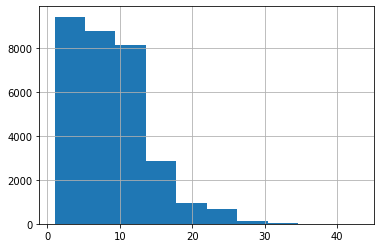

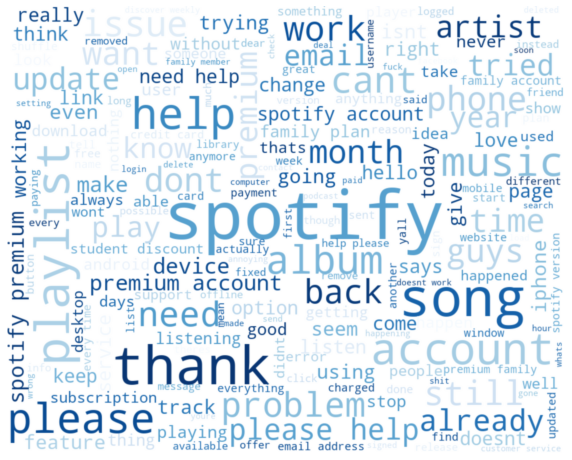

In [ ]:
tweetsWordsDistribution(spotify_tweets.text)
frequentWordsWordCloud(spotify_tweets.text)

Top 10 Unigrams


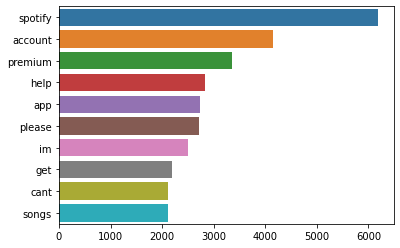

In [ ]:
print("Top 10 Unigrams")
visualizeNGrams(spotify_tweets.text, 1)

Top 10 Bigrams


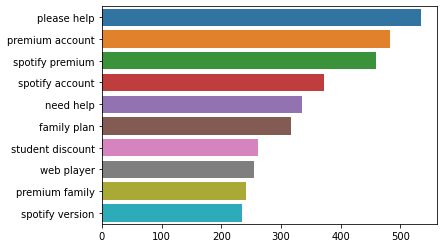

In [ ]:
print("Top 10 Bigrams")
visualizeNGrams(spotify_tweets.text, 2)

Top 10 Trigrams


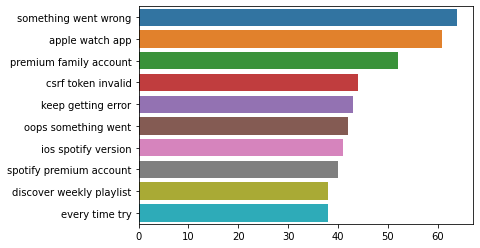

In [ ]:
print("Top 10 Trigrams")
visualizeNGrams(spotify_tweets.text, 3)

Doc-term matrix shape:  (30921, 1000)

Topic 0:  spotify account help premium thanks im app 
Topic 1:  thanks reply ok guys dm worked ill 
Topic 2:  help account premium email need family student 
Topic 3:  thank help okay worked dm ok yes 
Topic 4:  spotify account premium thanks thank email student 
Topic 5:  help spotify need version iphone ios dm 
Topic 6:  iphone app ios version update account premium 
Topic 7:  account email facebook password address hacked changed 
Topic 8:  version iphone ios songs im playlist using 
Topic 9:  im email using music version android dm 
Topic 10:  album new available need hey iphone update 
Topic 11:  email dm sent hi family address plan 
Topic 12:  need music dm iphone hey guys update 
Topic 13:  dm account sent hi songs app im 
Topic 14:  music family version hi dm song plan 
Topic 15:  need version songs android email premium app 
Topic 16:  hey family add playlist need plan song 
Topic 17:  version song hey android dont available student 
Topi

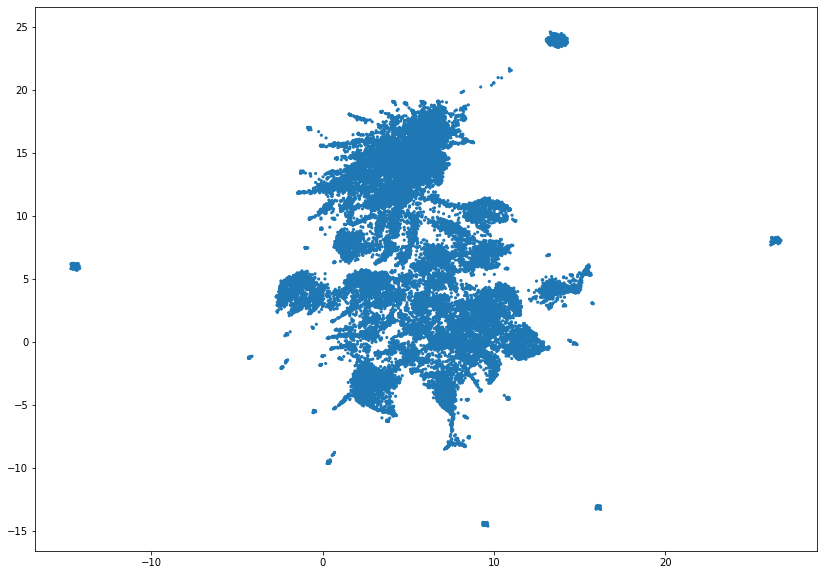

In [ ]:
# considering 1000 features and 20 topics
lsaAlgo(spotify_tweets.text, 1000, 20)


Coherence Score (c_v):  0.31189975170867434

Coherence Score (u_mass):  -5.375064386688071

Topic: 0 Words: 0.064*"thank" + 0.019*"hulu" + 0.017*"account" + 0.016*"premium" + 0.016*"still" + 0.013*"spotify" + 0.012*"student" + 0.011*"help" + 0.009*"paid" + 0.009*"accounts"
Topic: 1 Words: 0.011*"dm" + 0.009*"weekly" + 0.009*"discover" + 0.008*"check" + 0.008*"spotify" + 0.008*"please" + 0.007*"songs" + 0.007*"galaxy" + 0.007*"guys" + 0.007*"happen"
Topic: 2 Words: 0.026*"" + 0.022*"ios" + 0.018*"app" + 0.017*"version" + 0.016*"fix" + 0.016*"spotify" + 0.014*"iphone" + 0.013*"cant" + 0.011*"please" + 0.011*"add"
Topic: 3 Words: 0.019*"available" + 0.016*"okay" + 0.012*"spotify" + 0.010*"app" + 0.009*"pay" + 0.008*"please" + 0.008*"premium" + 0.007*"ive" + 0.007*"account" + 0.007*"help"
Topic: 4 Words: 0.013*"fuck" + 0.011*"care" + 0.009*"spotify" + 0.008*"awesome" + 0.008*"work" + 0.007*"one" + 0.007*"app" + 0.007*"thanks" + 0.007*"music" + 0.006*"playlist"
Topic: 5 Words: 0.031*"x" + 

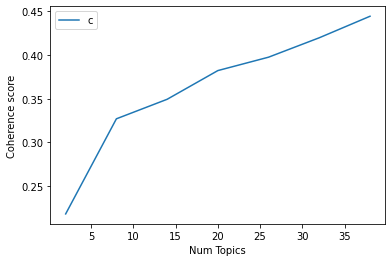

In [ ]:
# considering tf-idf and 20 topics
pyLDAvis.enable_notebook()
pyLDAvis.display(ldaAlgo(spotify_tweets.text, False, 20))

In [13]:
model = bertTopic(company, 20, spotify_tweets)
model.visualize_topics()

Topic 0:  [('premium', 0.06940680291504835), ('spotify', 0.04606404693528284), ('payment', 0.043853979930178894), ('card', 0.039744625984178335), ('charged', 0.03966801179079024), ('free', 0.036924841487579615), ('account', 0.036001489345265376), ('subscription', 0.033175684915459774), ('help', 0.02862627369061068), ('cancel', 0.027666940378646945)]
Topic 1:  [('facebook', 0.11982191016050096), ('email', 0.08153187449760066), ('log', 0.07703812437634235), ('account', 0.07377361206394667), ('password', 0.06753637658477905), ('login', 0.060279164326551386), ('fb', 0.05487998108748674), ('reset', 0.04797274007622428), ('cant', 0.04764098451862852), ('help', 0.03800282268413565)]
Topic 2:  [('family', 0.2155910209915713), ('plan', 0.0976415820156718), ('invite', 0.05967767041079957), ('premium', 0.05818476348933584), ('account', 0.05303454905126886), ('address', 0.04534484018273224), ('members', 0.04341074248641016), ('join', 0.039450050019841094), ('help', 0.03697653335022715), ('add', 0.

In [ ]:
spotify_tweets = extractTweetsToCompany(company)
print("Spotify tweets shape = ", spotify_tweets.shape)
spotify_tweets['text'] = spotify_tweets.apply(lambda row: preprocessTweets(row['text'], company), axis = 1)
spotify_tweets.head()

Spotify tweets shape =  (31584, 7)


tweet_id author_id  inbound                      created_at  \
545        853    115887     True  Tue Oct 31 19:57:59 +0000 2017   
553        862    115889     True  Tue Oct 31 21:43:56 +0000 2017   
555        864    115891     True  Tue Oct 31 22:22:05 +0000 2017   
557        866    115891     True  Tue Oct 31 22:14:42 +0000 2017   
1275      1872    116128     True  Tue Oct 31 22:48:33 +0000 2017   

                                                   text response_tweet_id  \
545                        iphone recent update spotify               852   
553   groove music quits amp redirect spotify w10m a...               860   
555                                              ok thx               863   
557                 way find nonexplicit songs explicit               865   
1275                                   1065320gac7a8e02              1873   

      in_response_to_tweet_id  
545                       854  
553                        -1  
555                       865  
557                        -1  
1275                     1871

In [ ]:
spotify_tweets = spotify_tweets['text']
spotify_tweets.head()

545                          iphone recent update spotify
553     groove music quits amp redirect spotify w10m a...
555                                                ok thx
557                   way find nonexplicit songs explicit
1275                                     1065320gac7a8e02
Name: text, dtype: object

In [ ]:
# convert dataframe to csv
spotify_tweets.to_csv('/content/spotify.csv')

## Uber

In [17]:
company = 'Uber_Support'

In [18]:
uber_tweets = pd.read_csv("/content/gdrive/MyDrive/ai4se/pp_files/uber.csv")
uber_tweets = uber_tweets.dropna()
uber_tweets.head()

Unnamed: 0                                               text
0         466  need correct false charges trip lexington ky s...
1         468  driver drove department air travel instead air...
2         472  got threw door today went order sorry dont del...
3         475  phone number im literally stranded wait automa...
4         479   hour inside old altima smells ripped stain se...

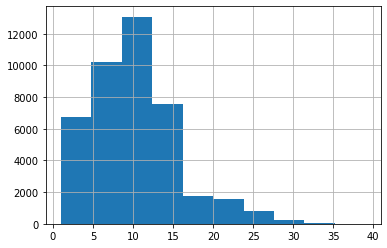

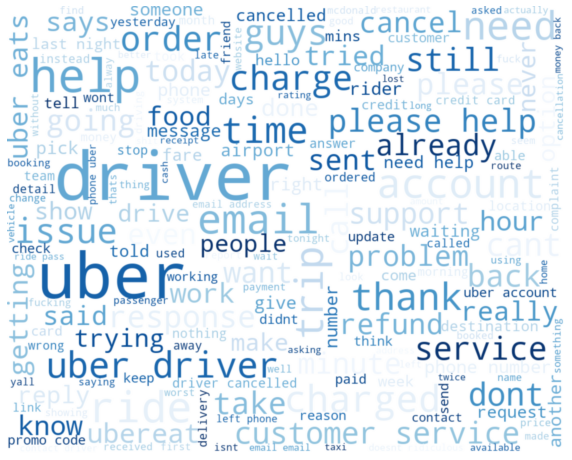

In [ ]:
tweetsWordsDistribution(uber_tweets.text)
frequentWordsWordCloud(uber_tweets.text)

Top 10 Unigrams


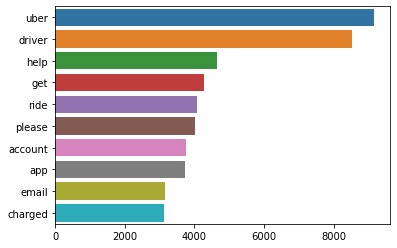

In [ ]:
print("Top 10 Unigrams")
visualizeNGrams(uber_tweets.text, 1)

Top 10 Bigrams


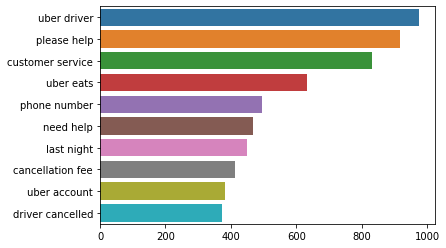

In [ ]:
print("Top 10 Bigrams")
visualizeNGrams(uber_tweets.text, 2)

Top 10 Trigrams


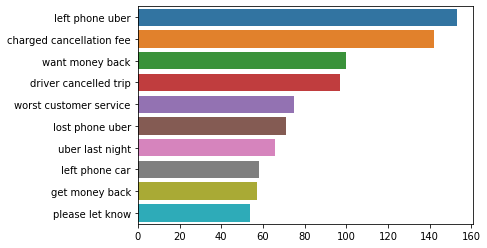

In [ ]:
print("Top 10 Trigrams")
visualizeNGrams(uber_tweets.text, 3)

Doc-term matrix shape:  (41944, 1000)

Topic 0:  uber driver help email account ride phone 
Topic 1:  email sent address dm account id number 
Topic 2:  help need account phone dm number sent 
Topic 3:  dm sent check thanks response reply message 
Topic 4:  uber account phone eats number dm sent 
Topic 5:  driver uber help dm left sent car 
Topic 6:  account ride charged uber card got disabled 
Topic 7:  account phone number driver contact left trip 
Topic 8:  ride phone drivers number customer need service 
Topic 9:  service customer account drivers need trip dm 
Topic 10:  drivers need app dm check dont car 
Topic 11:  app sent driver response trip account support 
Topic 12:  sent drivers phone charged response trip message 
Topic 13:  charged trip phone app dm number drivers 
Topic 14:  need charged contact response trip refund support 
Topic 15:  response waiting thanks reply support issue got 
Topic 16:  thanks hi car guys got reply trip 
Topic 17:  got charged app car drivers acc

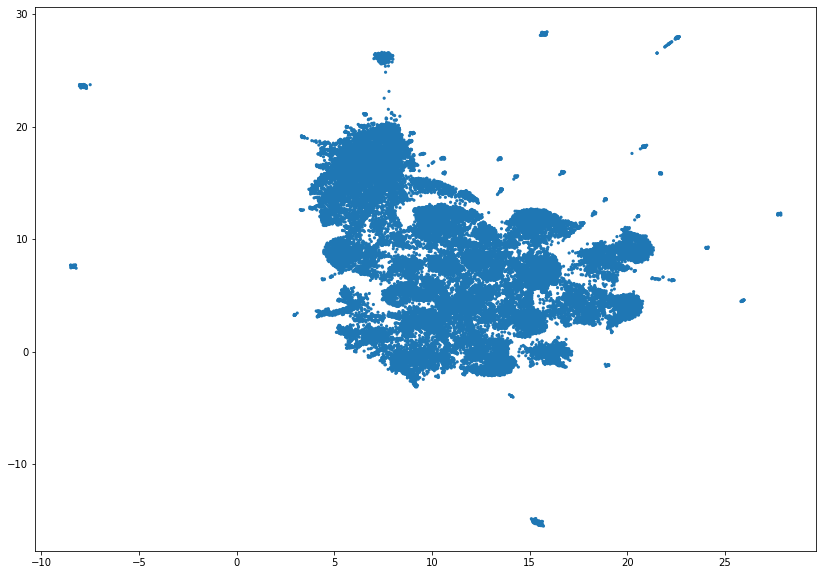

In [ ]:
# considering 1000 features and 20 topics
lsaAlgo(uber_tweets.text, 1000, 20)


Coherence Score (c_v):  0.3093608535428144

Coherence Score (u_mass):  -3.947340567356406

Topic: 0 Words: 0.054*"sent" + 0.054*"dm" + 0.042*"done" + 0.015*"please" + 0.011*"thanks" + 0.011*"reply" + 0.010*"check" + 0.009*"note" + 0.009*"email" + 0.008*"already"
Topic: 1 Words: 0.017*"check" + 0.016*"order" + 0.009*"please" + 0.009*"driver" + 0.008*"food" + 0.008*"dm" + 0.008*"missing" + 0.007*"dms" + 0.007*"cancelled" + 0.007*"charged"
Topic: 2 Words: 0.010*"wtf" + 0.009*"uber" + 0.009*"account" + 0.008*"talk" + 0.007*"need" + 0.007*"phone" + 0.007*"please" + 0.006*"driver" + 0.006*"bank" + 0.006*"human"
Topic: 3 Words: 0.013*"driver" + 0.011*"" + 0.011*"uber" + 0.010*"thank" + 0.009*"charged" + 0.009*"complaint" + 0.009*"trip" + 0.008*"ride" + 0.007*"picked" + 0.007*"got"
Topic: 4 Words: 0.014*"response" + 0.011*"email" + 0.010*"uber" + 0.009*"delete" + 0.009*"account" + 0.008*"ride" + 0.007*"driver" + 0.006*"still" + 0.006*"get" + 0.006*"card"
Topic: 5 Words: 0.075*"email" + 0.011*

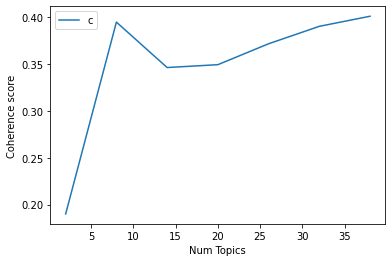

In [ ]:
# considering tf-idf and 20 topics
pyLDAvis.enable_notebook()
pyLDAvis.display(ldaAlgo(uber_tweets.text, False, 20))

In [19]:
model = bertTopic(company, 20, uber_tweets)
model.visualize_topics()

Topic 0:  [('cancel', 0.06504268951834118), ('cancelled', 0.06278678608826312), ('cancellation', 0.060249802301829025), ('charged', 0.05799622789789588), ('driver', 0.05492906608453671), ('fee', 0.05094218961198322), ('uber', 0.04615172570800369), ('ride', 0.03822165869862743), ('trip', 0.03417408352391029), ('canceled', 0.02517214593279339)]
Topic 1:  [('dm', 0.35110868882539514), ('sent', 0.23662844960723586), ('check', 0.15603594286426353), ('note', 0.10154959917515155), ('please', 0.08399097235557368), ('background', 0.05499657779086075), ('dmed', 0.053886891058022704), ('dms', 0.0473940670587026), ('thanks', 0.046957016045398745), ('send', 0.04637583856208304)]
Topic 2:  [('phone', 0.11857406577867259), ('left', 0.10277405171431671), ('lost', 0.07663902799807747), ('help', 0.07398247656866573), ('uber', 0.0536044578677235), ('driver', 0.04874999690553334), ('contact', 0.04872305642353644), ('please', 0.0471767819854752), ('car', 0.046217462234229234), ('item', 0.03575505246513372)

In [ ]:
uber_tweets = extractTweetsToCompany(company)
print("Uber tweets shape = ", uber_tweets.shape)
uber_tweets['text'] = uber_tweets.apply(lambda row: preprocessTweets(row['text'], company), axis = 1)
uber_tweets.head()

Uber tweets shape =  (42476, 7)


tweet_id author_id  inbound                      created_at  \
466       771    115872     True  Tue Oct 31 22:12:00 +0000 2017   
468       773    115874     True  Tue Oct 31 22:01:07 +0000 2017   
472       777    115876     True  Tue Oct 31 21:58:10 +0000 2017   
475       780    115878     True  Tue Oct 31 21:59:34 +0000 2017   
479       784    115880     True  Tue Oct 31 22:11:47 +0000 2017   

                                                  text response_tweet_id  \
466  need correct false charges trip lexington ky s...               768   
468  driver drove department air travel instead air...               772   
472  got threw door today went order sorry dont del...               776   
475  phone number im literally stranded wait automa...               778   
479   hour inside old altima smells ripped stain se...               783   

     in_response_to_tweet_id  
466                       -1  
468                       -1  
472                       -1  
475                      781  
479                       -1

In [ ]:
uber_tweets = uber_tweets['text']
uber_tweets.head()

466    need correct false charges trip lexington ky s...
468    driver drove department air travel instead air...
472    got threw door today went order sorry dont del...
475    phone number im literally stranded wait automa...
479     hour inside old altima smells ripped stain se...
Name: text, dtype: object

In [ ]:
# convert dataframe to csv
uber_tweets.to_csv('/content/uber.csv')

## Hulu

In [8]:
company = 'hulu_support'

In [9]:
hulu_tweets = pd.read_csv("/content/gdrive/MyDrive/ai4se/pp_files/hulu.csv")
hulu_tweets = hulu_tweets.dropna()
hulu_tweets.head()

Unnamed: 0                                               text
0         721  wife hate new interface enjoy content getting ...
1         723  hi someone changed password hacked asked reset...
2         733       sounds like generic yourenotgonnafixit replh
3         737                              like student discount
4        1403            yes message error playing video iphone

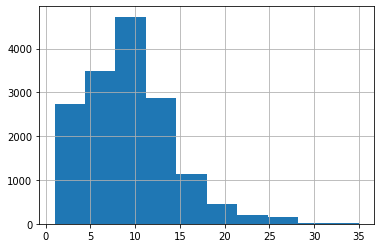

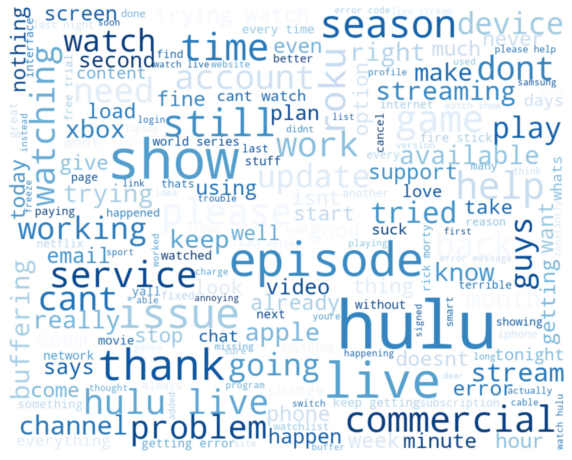

In [ ]:
tweetsWordsDistribution(hulu_tweets.text)
frequentWordsWordCloud(hulu_tweets.text)

Top 10 Unigrams


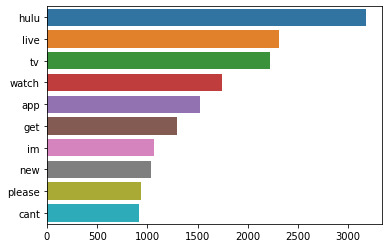

In [ ]:
print("Top 10 Unigrams")
visualizeNGrams(hulu_tweets.text, 1)

Top 10 Bigrams


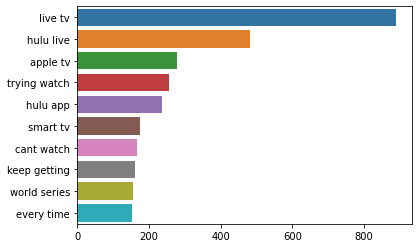

In [ ]:
print("Top 10 Bigrams")
visualizeNGrams(hulu_tweets.text, 2)

Top 10 Trigrams


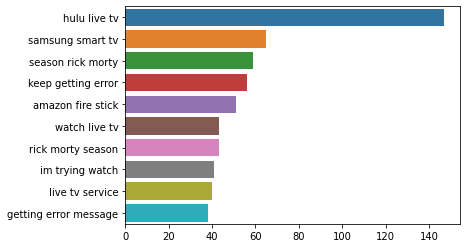

In [ ]:
print("Top 10 Trigrams")
visualizeNGrams(hulu_tweets.text, 3)

Doc-term matrix shape:  (15820, 1000)

Topic 0:  hulu live tv watch app season help 
Topic 1:  season hulu rick morty new episodes episode 
Topic 2:  live season tv rick morty buffering available 
Topic 3:  hulu live tv coming spotify season smart 
Topic 4:  watch game live trying hulu im help 
Topic 5:  help thanks need season working account error 
Topic 6:  thanks new episode episodes live hulu like 
Topic 7:  help need new episodes account episode live 
Topic 8:  watch tv thanks app apple help smart 
Topic 9:  working app game roku watch help buffering 
Topic 10:  error episode working new episodes getting help 
Topic 11:  working episode thank im tv isnt commercials 
Topic 12:  episode game app watching help buffering fix 
Topic 13:  thank episode error available time fixed good 
Topic 14:  roku episode watch live stick service interface 
Topic 15:  service app live available watch need error 
Topic 16:  need commercials live app shows watching ads 
Topic 17:  need tv fix game err

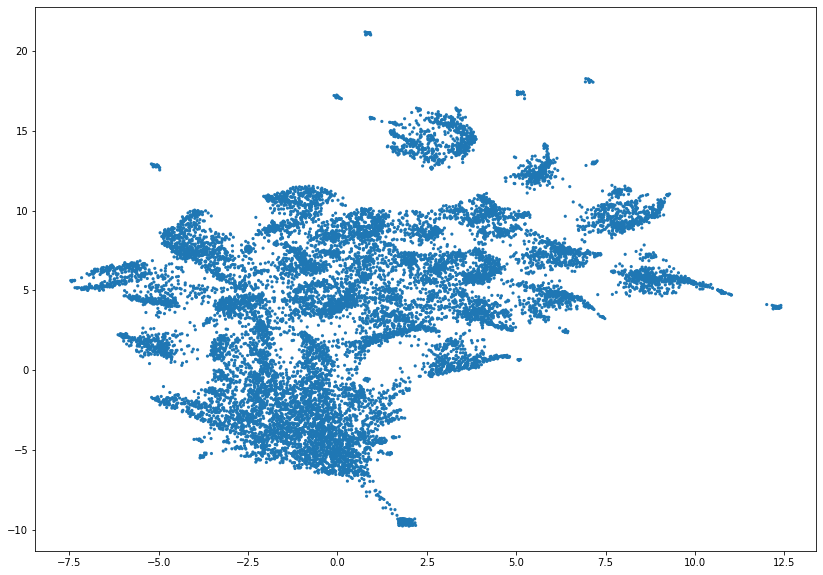

In [ ]:
# considering 1000 features and 20 topics
lsaAlgo(hulu_tweets.text, 1000, 20)


Coherence Score (c_v):  0.2611878258010763

Coherence Score (u_mass):  -4.302050524422429

Topic: 0 Words: 0.014*"available" + 0.013*"going" + 0.012*"hulu" + 0.010*"live" + 0.008*"get" + 0.008*"season" + 0.008*"tv" + 0.008*"time" + 0.007*"u" + 0.007*"watch"
Topic: 1 Words: 0.010*"service" + 0.010*"issue" + 0.010*"charged" + 0.008*"still" + 0.008*"live" + 0.008*"need" + 0.008*"hulu" + 0.007*"get" + 0.006*"dont" + 0.006*"free"
Topic: 2 Words: 0.012*"im" + 0.011*"error" + 0.010*"app" + 0.009*"getting" + 0.009*"live" + 0.009*"tv" + 0.009*"hulu" + 0.009*"watch" + 0.009*"streaming" + 0.008*"paying"
Topic: 3 Words: 0.023*"hulu" + 0.014*"live" + 0.010*"soon" + 0.010*"tv" + 0.010*"app" + 0.009*"fox" + 0.008*"issues" + 0.008*"season" + 0.007*"chrome" + 0.007*"watch"
Topic: 4 Words: 0.011*"hulu" + 0.009*"ads" + 0.009*"iphone" + 0.008*"app" + 0.008*"tv" + 0.008*"watch" + 0.008*"live" + 0.008*"today" + 0.006*"shows" + 0.006*"im"
Topic: 5 Words: 0.010*"tv" + 0.009*"hulu" + 0.008*"service" + 0.008*"

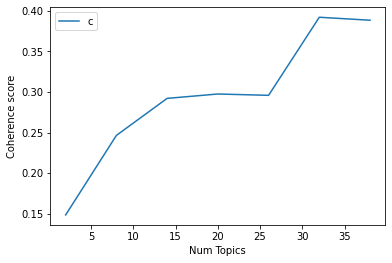

In [ ]:
# considering tf-idf and 20 topics
pyLDAvis.enable_notebook()
pyLDAvis.display(ldaAlgo(hulu_tweets.text, False, 20))

In [10]:
model = bertTopic(company, 20, hulu_tweets)
model.visualize_topics()

Topic 0:  [('commercials', 0.10746772437512936), ('ads', 0.10376832459251681), ('commercial', 0.06811614916717339), ('ad', 0.059682367582986506), ('pay', 0.03131505033860944), ('show', 0.030465386288307812), ('break', 0.03000999330583434), ('every', 0.024987358958808825), ('plan', 0.023506848325354143), ('watching', 0.023323111053093877)]
Topic 1:  [('spotify', 0.07344966869295158), ('account', 0.07143276935625993), ('charged', 0.0683155868120637), ('free', 0.06474891428772087), ('trial', 0.05595258331384414), ('month', 0.055582442399116604), ('hulu', 0.0513348861057828), ('student', 0.049995548066152175), ('cancel', 0.04435164851508229), ('subscription', 0.04377545492968443)]
Topic 2:  [('season', 0.288938671337748), ('rick', 0.1817433142412072), ('morty', 0.1781266267932569), ('seasons', 0.06694945699192219), ('put', 0.049787604341040716), ('broad', 0.0459157449810868), ('available', 0.043584943388978156), ('city', 0.04338867539910239), ('please', 0.03687436391460289), ('need', 0.035

In [ ]:
hulu_tweets = extractTweetsToCompany(company)
print("Hulu tweets shape = ", hulu_tweets.shape)
hulu_tweets['text'] = hulu_tweets.apply(lambda row: preprocessTweets(row['text'], company), axis = 1)
hulu_tweets.head()

Hulu tweets shape =  (15941, 7)


tweet_id author_id  inbound                      created_at  \
721       1260    115939     True  Mon Oct 30 01:02:34 +0000 2017   
723       1264    115941     True  Mon Oct 30 00:59:06 +0000 2017   
733       1274    115945     True  Tue Oct 31 22:43:10 +0000 2017   
737       1278    115947     True  Mon Oct 30 00:50:40 +0000 2017   
1403      2089    116166     True  Mon Oct 30 01:18:51 +0000 2017   

                                                   text response_tweet_id  \
721   wife hate new interface enjoy content getting ...              1258   
723   hi someone changed password hacked asked reset...              1263   
733        sounds like generic yourenotgonnafixit replh              1276   
737                               like student discount              1277   
1403            yes message error playing video iphone               2088   

      in_response_to_tweet_id  
721                        -1  
723                        -1  
733                      1273  
737                      1279  
1403                     2090

In [ ]:
hulu_tweets = hulu_tweets['text']
hulu_tweets.head()

721     wife hate new interface enjoy content getting ...
723     hi someone changed password hacked asked reset...
733          sounds like generic yourenotgonnafixit replh
737                                 like student discount
1403              yes message error playing video iphone 
Name: text, dtype: object

In [ ]:
# convert dataframe to csv
hulu_tweets.to_csv('/content/hulu.csv')

## Spectrum

In [5]:
company = 'Ask_Spectrum'

In [6]:
spectrum_tweets = pd.read_csv("/content/gdrive/MyDrive/ai4se/pp_files/spectrum.csv")
spectrum_tweets = spectrum_tweets.dropna()
spectrum_tweets.head()

Unnamed: 0                                               text
0          16  would like email copy one since spectrum updat...
1          18          received corporate office would like copy
2          21  incorrect information form front faxed overmay...
3          23  actually thats broken link sent incorrect info...
4          27        picture pretty much every day pay per month

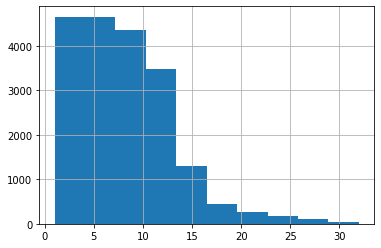

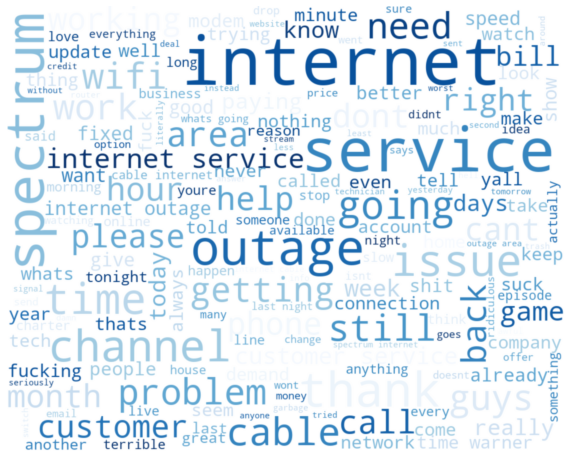

In [ ]:
tweetsWordsDistribution(spectrum_tweets.text)
frequentWordsWordCloud(spectrum_tweets.text)

Top 10 Unigrams


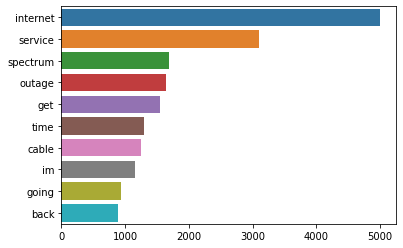

In [ ]:
print("Top 10 Unigrams")
visualizeNGrams(spectrum_tweets.text, 1)

Top 10 Bigrams


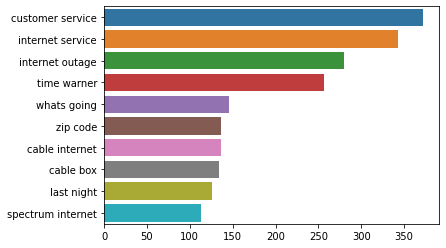

In [ ]:
print("Top 10 Bigrams")
visualizeNGrams(spectrum_tweets.text, 2)

Top 10 Trigrams


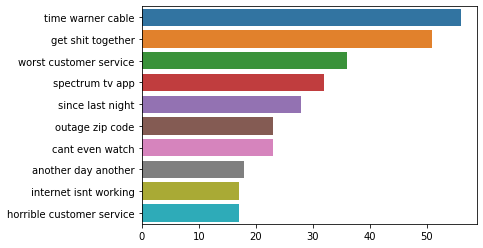

In [ ]:
print("Top 10 Trigrams")
visualizeNGrams(spectrum_tweets.text, 3)

Doc-term matrix shape:  (19481, 1000)

Topic 0:  internet outage service spectrum area cable going 
Topic 1:  outage area service zip code eta nyc 
Topic 2:  service spectrum customer time thanks im cable 
Topic 3:  service internet customer restored eta horrible worst 
Topic 4:  thanks working thank ok came good help 
Topic 5:  spectrum thanks service internet tv app worst 
Topic 6:  thank working spectrum yes tv app issue 
Topic 7:  cable working time box warner service thanks 
Topic 8:  working area tv app isnt going issues 
Topic 9:  going whats cable spectrum thank thanks area 
Topic 10:  area cable issues code outages fix issue 
Topic 11:  time area warner working issues outages week 
Topic 12:  fix wifi going spectrum shit time working 
Topic 13:  wifi spectrum im cable help sucks need 
Topic 14:  help tv wifi need app phone work 
Topic 15:  help need working dont phone customer fix 
Topic 16:  im tv help app getting fix time 
Topic 17:  game channel help watch hey channels area

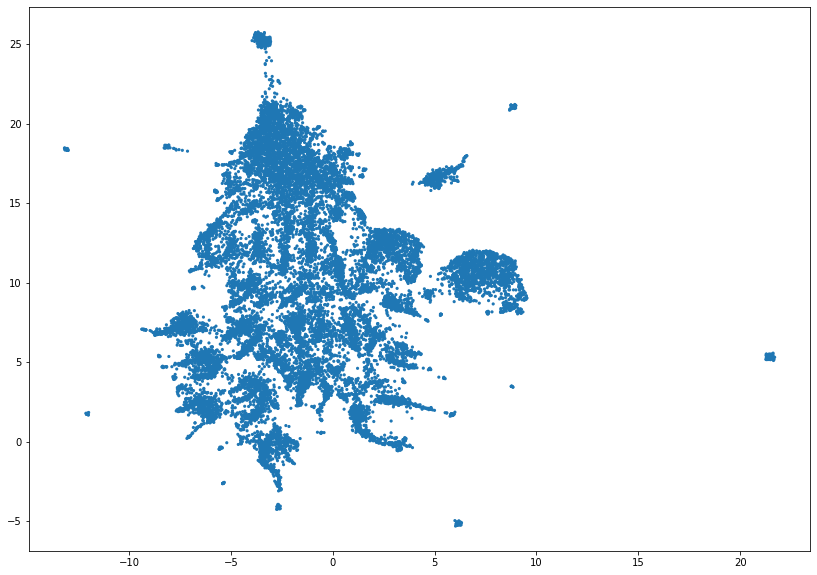

In [ ]:
# considering 1000 features and 20 topics
lsaAlgo(spectrum_tweets.text, 1000, 20)


Coherence Score (c_v):  0.2549344822586489

Coherence Score (u_mass):  -5.747943993429958

Topic: 0 Words: 0.011*"looks" + 0.011*"service" + 0.011*"like" + 0.011*"app" + 0.010*"channel" + 0.010*"horrible" + 0.009*"spectrum" + 0.009*"customer" + 0.008*"internet" + 0.008*"im"
Topic: 1 Words: 0.017*"wtf" + 0.016*"went" + 0.011*"nope" + 0.010*"internet" + 0.010*"updates" + 0.009*"service" + 0.009*"get" + 0.009*"together" + 0.008*"well" + 0.008*"spectrum"
Topic: 2 Words: 0.055*"" + 0.054*"internet" + 0.048*"outage" + 0.020*"area" + 0.019*"service" + 0.013*"still" + 0.009*"eta" + 0.009*"austin" + 0.009*"san" + 0.008*"tx"
Topic: 3 Words: 0.014*"internet" + 0.013*"ohio" + 0.012*"bill" + 0.011*"outage" + 0.011*"literally" + 0.010*"service" + 0.009*"pay" + 0.009*"another" + 0.008*"spectrum" + 0.008*"company"
Topic: 4 Words: 0.019*"fix" + 0.019*"tv" + 0.017*"internet" + 0.014*"cable" + 0.013*"hate" + 0.011*"ridiculous" + 0.011*"texas" + 0.011*"gives" + 0.010*"fixed" + 0.009*"service"
Topic: 5 Wo

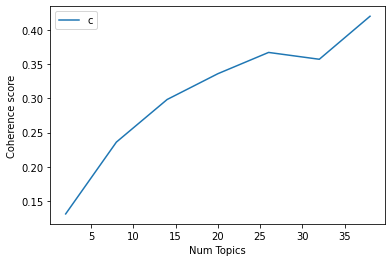

In [ ]:
# considering tf-idf and 20 topics
pyLDAvis.enable_notebook()
pyLDAvis.display(ldaAlgo(spectrum_tweets.text, False, 20))

In [7]:
model = bertTopic(company, 20, spectrum_tweets)
model.visualize_topics()

Downloading:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/612 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/116 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/350 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/13.2k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/349 [00:00<?, ?B/s]

Topic 0:  [('outage', 0.20911964086843787), ('outages', 0.0847301731807331), ('area', 0.08226845459305256), ('another', 0.04801972694158113), ('internet', 0.04755511170849398), ('ok', 0.03535615728435877), ('service', 0.023945859730339174), ('thanks', 0.020057883715059958), ('code', 0.019659458986071875), ('week', 0.018287428833253058)]
Topic 1:  [('spectrum', 0.17820437840667486), ('internet', 0.059046020678566354), ('outage', 0.037729243730172085), ('spectrumoutage', 0.028916587967606718), ('outages', 0.019291606757691183), ('get', 0.01879966976441545), ('area', 0.016640149513808013), ('since', 0.015609966376753442), ('spectrumsucks', 0.01505066993629556), ('wifi', 0.014896370822120758)]
Topic 2:  [('app', 0.18970666807669953), ('tv', 0.08937924721087699), ('roku', 0.07681157020584535), ('spectrum', 0.07007593337325017), ('login', 0.0523745319000677), ('password', 0.03582762633168927), ('log', 0.03501095690982447), ('error', 0.033198441409979094), ('apps', 0.029534434150415654), ('ac

In [ ]:
spectrum_tweets = extractTweetsToCompany(company)
print("Spectrum tweets shape = ", spectrum_tweets.shape)
spectrum_tweets['text'] = spectrum_tweets.apply(lambda row: preprocessTweets(row['text'], company), axis = 1)
spectrum_tweets.head()

Spectrum tweets shape =  (19696, 7)


tweet_id author_id  inbound                      created_at  \
16        22    115716     True  Tue Oct 31 22:16:48 +0000 2017   
18        26    115716     True  Tue Oct 31 22:19:56 +0000 2017   
21        24    115716     True  Tue Oct 31 22:13:02 +0000 2017   
23        29    115716     True  Tue Oct 31 22:01:35 +0000 2017   
27        33    115718     True  Tue Oct 31 22:06:56 +0000 2017   

                                                 text response_tweet_id  \
16  would like email copy one since spectrum updat...                25   
18          received corporate office would like copy                27   
21  incorrect information form front faxed overmay...                21   
23  actually thats broken link sent incorrect info...                28   
27        picture pretty much every day pay per month                32   

    in_response_to_tweet_id  
16                       21  
18                       25  
21                       28  
23                       -1  
27                       -1

In [ ]:
spectrum_tweets = spectrum_tweets['text']
spectrum_tweets.head()

16    would like email copy one since spectrum updat...
18            received corporate office would like copy
21    incorrect information form front faxed overmay...
23    actually thats broken link sent incorrect info...
27          picture pretty much every day pay per month
Name: text, dtype: object

In [ ]:
# convert dataframe to csv
spectrum_tweets.to_csv('/content/spectrum.csv')